# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time
from tqdm import tqdm
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
#Importing all Keras Libraries

import tensorflow as tf
from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [3]:
!pip install gtts

In [4]:
from gtts import gTTS
from IPython.display import Audio

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [5]:
#Import the dataset and read the image into a seperate variable

images='../input/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [6]:
all_imgs

['../input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '../input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '../input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '../input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '../input/flickr8k/Images/2190227737_6e0bde2623.jpg',
 '../input/flickr8k/Images/2752809449_632cd991b3.jpg',
 '../input/flickr8k/Images/3097776588_312932e438.jpg',
 '../input/flickr8k/Images/1206506157_c7956accd5.jpg',
 '../input/flickr8k/Images/1319634306_816f21677f.jpg',
 '../input/flickr8k/Images/2465218087_fca77998c6.jpg',
 '../input/flickr8k/Images/3351493005_6e5030f596.jpg',
 '../input/flickr8k/Images/2949337912_beba55698b.jpg',
 '../input/flickr8k/Images/534886684_a6c9f40fa1.jpg',
 '../input/flickr8k/Images/3543600125_223747ef4c.jpg',
 '../input/flickr8k/Images/2174206711_11cb712a8d.jpg',
 '../input/flickr8k/Images/280706862_14c30d734a.jpg',
 '../input/flickr8k/Images/2100735137_05c6079537.jpg',
 '../input/flickr8k/Images/3131632154_098f86f4cb.jpg',
 '../input/fl

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):    
    text=open(filename).read()
    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)
    return keys,values,key_paths

text_file="../input/flickr8k/captions.txt"
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [9]:
#Create the vocabulary & the counter for the captions
def create_vocab(frame, column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out

vocabulary=create_vocab(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [10]:
#Visualise the top 30 occuring words in the captions
most_occur = val_count.most_common(30)
print(most_occur)

[('a', 40271), ('.', 34212), ('A', 21481), ('in', 18961), ('the', 15328), ('on', 10729), ('is', 9345), ('and', 8850), ('dog', 7982), ('with', 7760), ('man', 6828), ('of', 6712), ('Two', 3962), ('white', 3875), ('black', 3696), ('are', 3503), ('boy', 3442), ('woman', 3227), ('girl', 3217), (',', 3210), ('to', 3173), ('wearing', 3061), ('The', 2920), ('at', 2904), ('water', 2774), ('red', 2660), ('brown', 2475), ('people', 2442), ('young', 2431), ('."', 2365)]


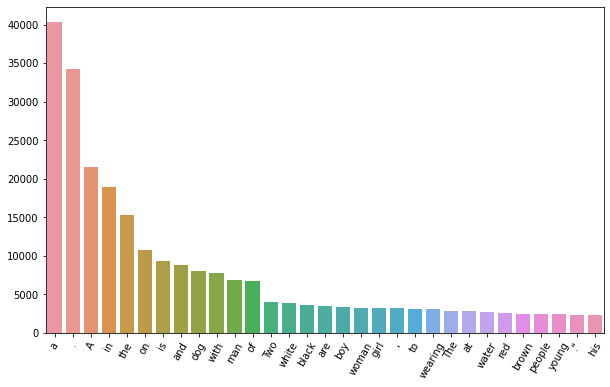

In [11]:
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

In [12]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [14]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [15]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

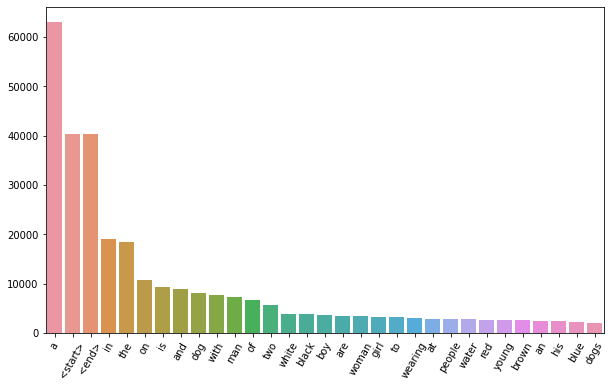

In [16]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [17]:
def maxElementOfAnArray(nested_array):
    array=[len(e) for e in nested_array]
    return max(array)
max_length=maxElementOfAnArray(train_seqs)

In [18]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_length) #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [19]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [20]:
#write your code here
def loadImage(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,file_path

Shape after resize : (299, 299, 3)


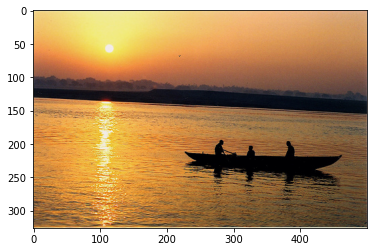

In [21]:
import matplotlib.image as mpimg
imgPathForTest = '../input/flickr8k/Images/223299137_b0e81ac145.jpg'
img , path = loadImage(imgPathForTest)
readImage =  mpimg.imread(path)
imgplot = plt.imshow(readImage)
print("Shape after resize :", img.shape)

In [22]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(loadImage, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [23]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [24]:
#write your code here
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [25]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [27]:
# tf.compat.v1.disable_eager_execution()

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [28]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 127/127 [01:01<00:00,  2.07it/s]


In [30]:
batch_f.shape

TensorShape([64, 2048])

In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [32]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [33]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [34]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [35]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [36]:
encoder=Encoder(embedding_dim)

### Attention model

In [37]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

### Decoder

In [38]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [39]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [40]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) 

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [41]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [42]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [43]:
checkpoint_path = "./Checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [46]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [47]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [48]:
loss_plot = []
test_loss_plot = []
EPOCHS = 12

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  8%|▊         | 1/12 [03:30<38:39, 210.83s/it]

For epoch: 1, the train loss is 1.274, & test loss is 1.054
Time taken for 1 epoch 210.66985177993774 sec

Test loss has been reduced from 100.000 to 1.054


 17%|█▋        | 2/12 [04:59<23:07, 138.80s/it]

For epoch: 2, the train loss is 0.969, & test loss is 0.927
Time taken for 1 epoch 88.22037959098816 sec

Test loss has been reduced from 1.054 to 0.927


 25%|██▌       | 3/12 [06:27<17:22, 115.88s/it]

For epoch: 3, the train loss is 0.878, & test loss is 0.853
Time taken for 1 epoch 88.42341208457947 sec

Test loss has been reduced from 0.927 to 0.853


 33%|███▎      | 4/12 [07:55<13:58, 104.81s/it]

For epoch: 4, the train loss is 0.818, & test loss is 0.798
Time taken for 1 epoch 87.6817216873169 sec

Test loss has been reduced from 0.853 to 0.798
For epoch: 5, the train loss is 0.769, & test loss is 0.752
Time taken for 1 epoch 87.74781799316406 sec

Test loss has been reduced from 0.798 to 0.752


 50%|█████     | 6/12 [10:51<09:30, 95.14s/it] 

For epoch: 6, the train loss is 0.725, & test loss is 0.712
Time taken for 1 epoch 87.96892166137695 sec

Test loss has been reduced from 0.752 to 0.712


 58%|█████▊    | 7/12 [12:20<07:44, 92.88s/it]

For epoch: 7, the train loss is 0.687, & test loss is 0.675
Time taken for 1 epoch 88.06600379943848 sec

Test loss has been reduced from 0.712 to 0.675


 67%|██████▋   | 8/12 [13:48<06:05, 91.40s/it]

For epoch: 8, the train loss is 0.652, & test loss is 0.639
Time taken for 1 epoch 88.08788967132568 sec

Test loss has been reduced from 0.675 to 0.639


 75%|███████▌  | 9/12 [15:16<04:30, 90.32s/it]

For epoch: 9, the train loss is 0.620, & test loss is 0.608
Time taken for 1 epoch 87.77291870117188 sec

Test loss has been reduced from 0.639 to 0.608


 83%|████████▎ | 10/12 [16:44<02:59, 89.62s/it]

For epoch: 10, the train loss is 0.589, & test loss is 0.578
Time taken for 1 epoch 87.9036808013916 sec

Test loss has been reduced from 0.608 to 0.578


 92%|█████████▏| 11/12 [18:12<01:29, 89.08s/it]

For epoch: 11, the train loss is 0.561, & test loss is 0.552
Time taken for 1 epoch 87.72629356384277 sec

Test loss has been reduced from 0.578 to 0.552


100%|██████████| 12/12 [19:40<00:00, 98.35s/it]

For epoch: 12, the train loss is 0.535, & test loss is 0.526
Time taken for 1 epoch 87.94913673400879 sec

Test loss has been reduced from 0.552 to 0.526


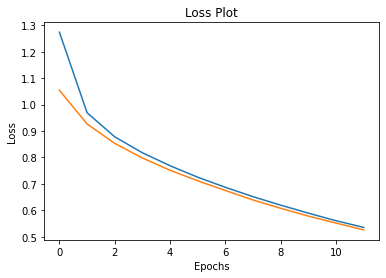

In [49]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [50]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(loadImage(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [76]:
def beam_evaluate(image, beam_index = 1):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(loadImage(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [52]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [53]:
from nltk.translate.bleu_score import sentence_bleu

In [54]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [55]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score1: 60.13781189421007
BELU score2: 48.5986909669908
BELU score3: 32.61258285505894
BELU score4: 36.92701967267332
Real Caption: A group of teens sit on a wall by a beach
Prediction Caption: a group of people sit on a beach


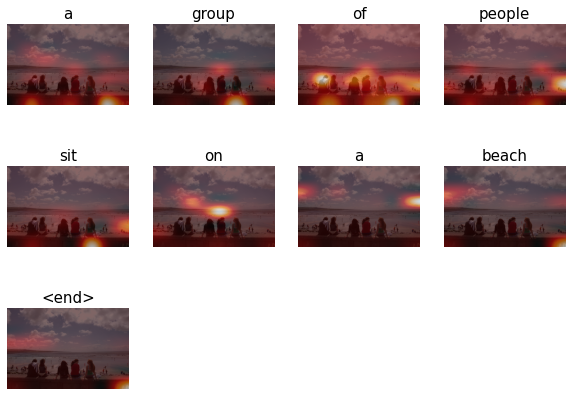

In [56]:
test_image = '../input/flickr8k/Images/1048710776_bb5b0a5c7c.jpg'
real_caption = '<start> A group of teens sit on a wall by a beach <end>'
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BELU score1: {score1*100}")
print(f"BELU score2: {score2*100}")
print(f"BELU score3: {score3*100}")
print(f"BELU score4: {score4*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

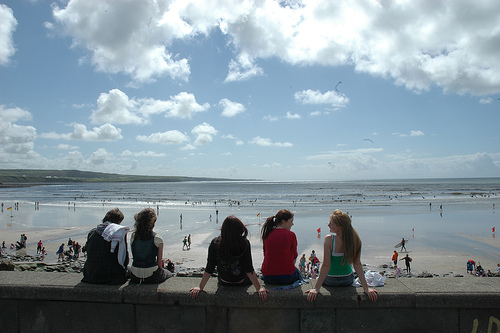

In [57]:
Image.open(test_image)

BELU score1: 53.84615384615385
BELU score2: 47.36654667156709
BELU score3: 43.251542912584036
BELU score4: 33.260249505555045
Real Caption: a man eats near a tent in the snow
Prediction Caption: a man sitting on snow in front of a tent in the snow


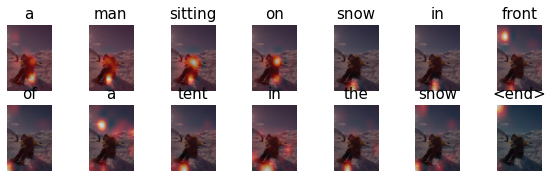

In [58]:
test_image = '../input/flickr8k/Images/116409198_0fe0c94f3b.jpg'
real_caption = '<start> a man eats near a tent in the snow <end>'

result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BELU score1: {score1*100}")
print(f"BELU score2: {score2*100}")
print(f"BELU score3: {score3*100}")
print(f"BELU score4: {score4*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

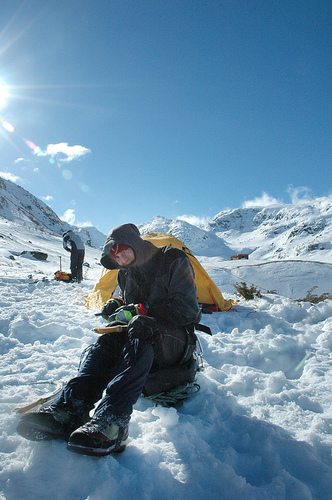

In [59]:
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score1: 11.111111111111109
BELU score2: 33.33333333333333
BELU score3: 51.72818579717866
BELU score4: 57.735026918962575
Real Caption: A person wearing scuba gear is swimming underwater water
Prediction Caption: a scuba diver submerged scuba diving in the ocean


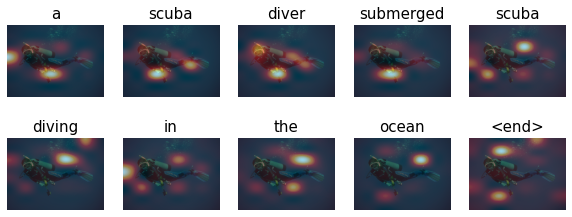

In [74]:
test_image = '../input/flickr8k/Images/2178306830_6af49375b4.jpg'
real_caption = '<start> A person wearing scuba gear is swimming underwater water <end>'

result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BELU score1: {score1*100}")
print(f"BELU score2: {score2*100}")
print(f"BELU score3: {score3*100}")
print(f"BELU score4: {score4*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

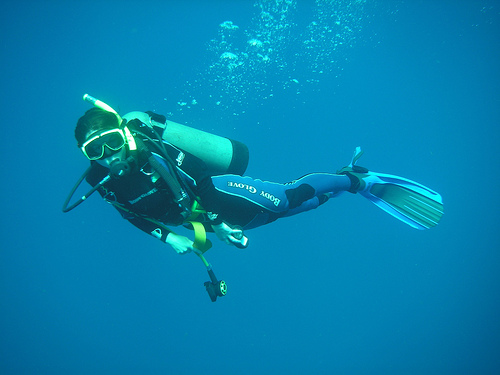

In [61]:
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score1: 41.66666666666667
BELU score2: 27.524094128159014
BELU score3: 46.11347179371555
BELU score4: 52.463410228614585
Real Caption: A man in a paddle boat on a lake
Prediction Caption: a man is rowing a canoe in a canoe in a lake


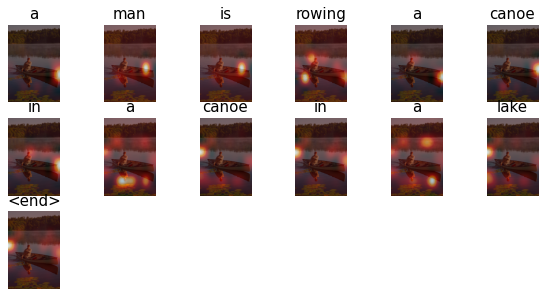

In [62]:
test_image = '../input/flickr8k/Images/217838128_1f0a84ddc1.jpg'
real_caption = '<start> A man in a paddle boat on a lake <end>'

result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BELU score1: {score1*100}")
print(f"BELU score2: {score2*100}")
print(f"BELU score3: {score3*100}")
print(f"BELU score4: {score4*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

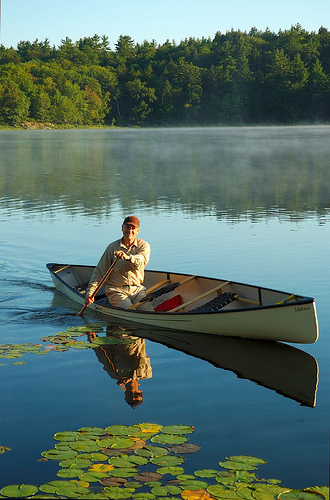

In [63]:
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 17.615635478300696
Real Caption: a man is doing a jump on bicycle in an indoor skate and bike center
Prediction Caption: a man doing a trick on a ramp


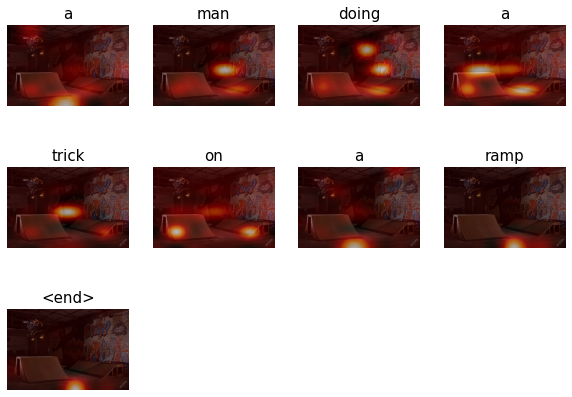

In [69]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

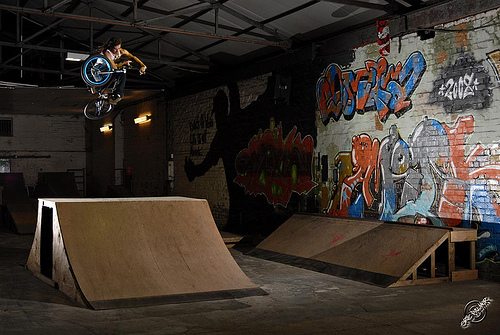

In [70]:
Image.open(test_image)

In [78]:
captionUsingBeamSearch = beam_evaluate(test_image)
print('Caption using Beam search: ', captionUsingBeamSearch)

Caption using Beam search:  person scuba diver submerged scuba gear underwater in diver underwater in diver underwater in diver underwater in diver underwater in diver underwater in diver underwater in diver underwater in diver underwater in diver underwater scuba suit submerged scuba
